Philippe Joly 2024-07-08

# Football Field Line Detection

This is a reproduction of the techniques used by [Junru Wang and Yuxuan Liu](https://mulab.ai/project/499-22-sports-analytics/) to detect lines on a football field. Various preprocessing techniques along with Hough Lines algorithm will be used to accomplish this task

## Loading Image

In [33]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

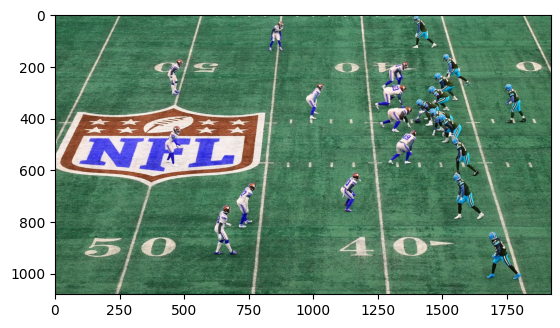

In [3]:
img_og = cv2.imread("test_img2.png")
plt.imshow(img_og)

## Preprocessing

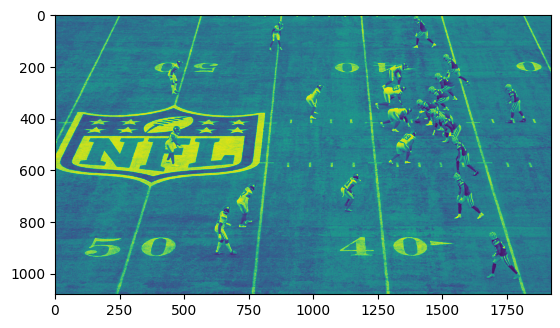

In [4]:
img = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

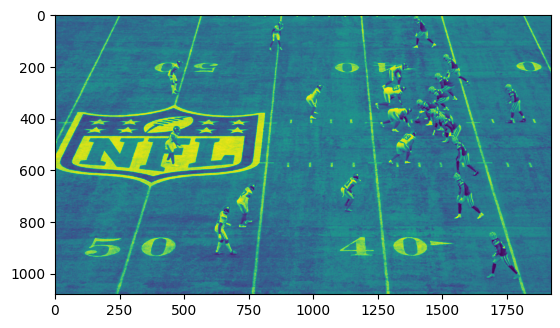

In [5]:
img = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(img)

## Line Detection

In [6]:
# edge detection using canny
edges = cv2.Canny(img, 75, 120)

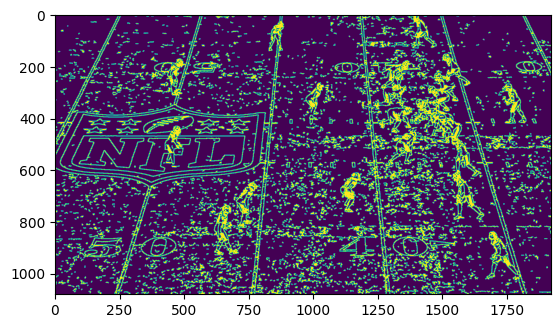

In [7]:
# dilation to enhance edges
kernel = np.ones((3,3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(edges)

In [8]:
# Hough Lines
## params
rho = 1  # Distance resolution in pixels
theta = np.pi / 180  # Angle resolution in radians
threshold = 100  # Accumulator threshold
minLineLength = 200  # Minimum length of a line
maxLineGap = 10  # Maximum allowed gap between points on the same line

lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)

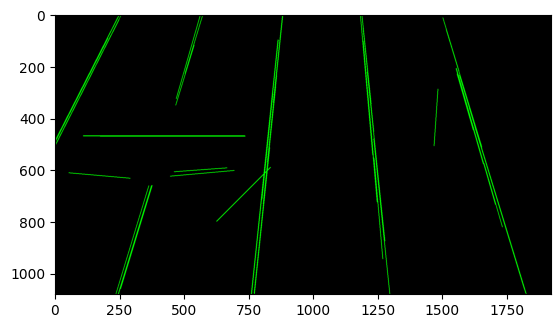

In [9]:
lines_draw = np.zeros_like(img_og)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(lines_draw)

## Merge Lines

In [27]:
def get_dis(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_basis(p1, p2):
    return p2-p1

def get_slope(p1, p2):
    basis = get_basis(p1,p2)
    return basis[1]/basis[0]

def project(basis, v):
    return (np.dot(v, basis)/np.dot(v, v) * v).astype(np.int64)

In [23]:
line_list = []
for line in lines:
    p1 = np.array(line[0][:2])
    p2 = np.array(line[0][2:])
    line_list.append({'p1': p1, 'p2': p2, 'len': get_dis(p1, p2), 'basis': get_basis(p1, p2), 'slope': get_slope(p1, p2), 'merged': False, 'merges': 0})
line_list.sort(key=lambda x: x['len'])

In [24]:
def get_closest_pt(basis_line, p_l2):
    # assumes infinite basis_line
    v = p_l2 - basis_line['p1']
    delta = project(basis_line['basis'], v)
    closest = basis_line['p1'] + delta

    # take into account the finite nature of the basis_line
    dis_p1_closest = get_dis(basis_line['p1'], closest)
    dis_p2_closest = get_dis(basis_line['p2'], closest)
    
    if dis_p1_closest > dis_p2_closest:
        if dis_p1_closest > basis_line['len']:
            closest = basis_line['p2']
    else:
        if dis_p2_closest > basis_line['len']:
            closest = basis_line['p1']
    
    return closest
 
def dis_to_line(basis_line, p_l2):
    p_l1 = get_closest_pt(basis_line, p_l2)
    return get_dis(p_l1, p_l2)

def merge_lines(basis_line, merged_line):
    v1 = merged_line['p1'] - basis_line['p1']
    v2 = merged_line['p2'] - basis_line['p1']

    delta1 = project(basis_line['basis'], v1)
    delta2 = project(basis_line['basis'], v2)

    c1 = basis_line['p1'] + delta1
    c2 = basis_line['p1'] + delta2

    dis_p1_c1 = get_dis(basis_line['p1'], c1)
    dis_p2_c1 = get_dis(basis_line['p2'], c1)
    dis_p1_c2 = get_dis(basis_line['p1'], c2)
    dis_p2_c2 = get_dis(basis_line['p2'], c2)
    
    # if line extends further than basis, simply elongate basis
    if dis_p1_c1 > dis_p2_c1:
        if dis_p1_c1 > basis_line['len']:
            basis_line['p2'] = c1
    else:
        if dis_p1_c1 > basis_line['len']:
            basis_line['p1'] = c1

    if dis_p1_c2 > dis_p2_c2:
        if dis_p1_c2 > basis_line['len']:
            basis_line['p2'] = c2
    else:
        if dis_p1_c2 > basis_line['len']:
            basis_line['p1'] = c2

    merged_line['merged'] = True
    basis_line['merges'] += 1   

    ### ***handle out of bounds projections*** 
    

In [25]:
def should_merge(basis_line, merged_line, slope_treshold, dis_treshold):
    # the edges of merged_line suffice to find closest distance between the 2 lines as they are supposidely parallel and the merged_line is always shorter than the basis_line (sorted)

    if basis_line['slope'] - merged_line['slope'] < slope_treshold:
        dis_p1 = dis_to_line(basis_line, merged_line['p1'])
        dis_p2 = dis_to_line(basis_line, merged_line['p2'])

        if dis_p1 < dis_treshold or dis_p2 < dis_treshold:
            return True

In [42]:
# main merging loop
list_length = len(line_list)
for i in range(list_length-1):
    for j in range(i+1, list_length):
        if should_merge(line_list[j], line_list[i], 1, 50):
            merge_lines(line_list[j], line_list[i])

merged_lines = [x for x in line_list if not x['merged']]

In [39]:
df = pd.DataFrame(merged_lines)
df.tail()

,p1,p2,len,basis,slope,merged,merges
18,"[109, 470]","[734, 470]",625.000000,"[625, 0]",0.000000,False,5
19,"[1206, 223]","[1274, 875]",655.536422,"[68, 652]",9.588235,False,0
20,"[769, 1076]","[852, 281]",799.320962,"[83, -795]",-9.578313,False,1
21,"[1562, 236]","[1820, 1079]",881.596847,"[258, 843]",3.267442,False,5
22,"[758, 1079]","[861, 99]",985.397889,"[103, -980]",-9.514563,False,6


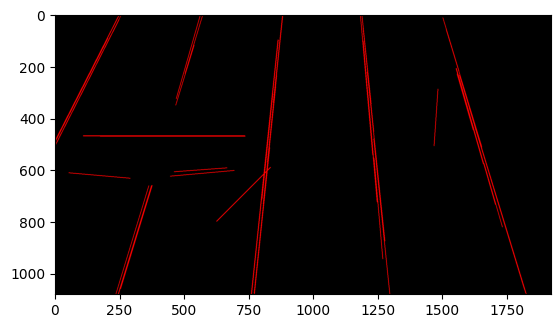

In [43]:
if line_list is not None:
    for line in line_list:
        cv2.line(lines_draw, (line['p1'][0], line['p1'][1]), (line['p2'][0], line['p2'][1]), (255, 0, 0), 2)

plt.imshow(lines_draw)